c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Dataset Loaded: (1470, 35)
 Class Distribution After SMOTE: [986 986]

 Correlation Heatmap:


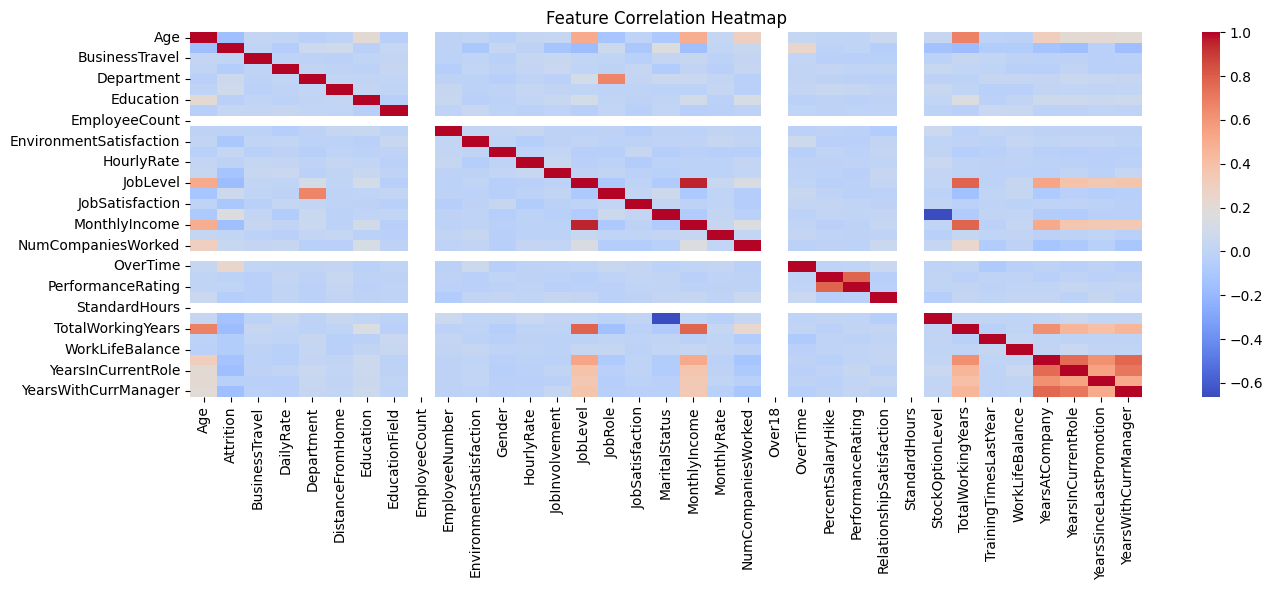

 OverTime vs Attrition


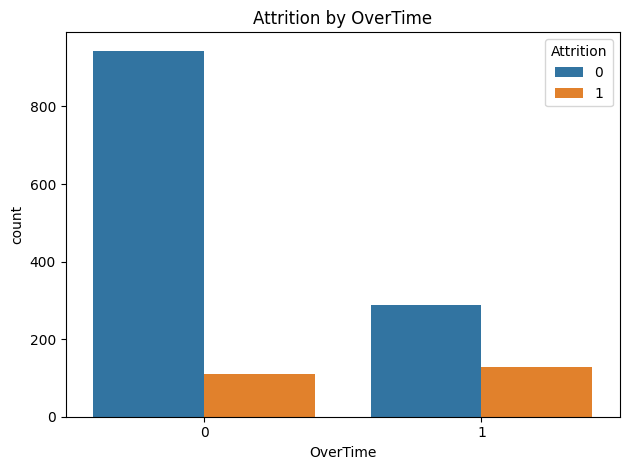


 XGBoost
Accuracy: 0.8299319727891157
Precision: 0.45714285714285713
Recall: 0.3404255319148936
F1 Score: 0.3902439024390244
ROC AUC: 0.7551899388405549
Confusion Matrix:



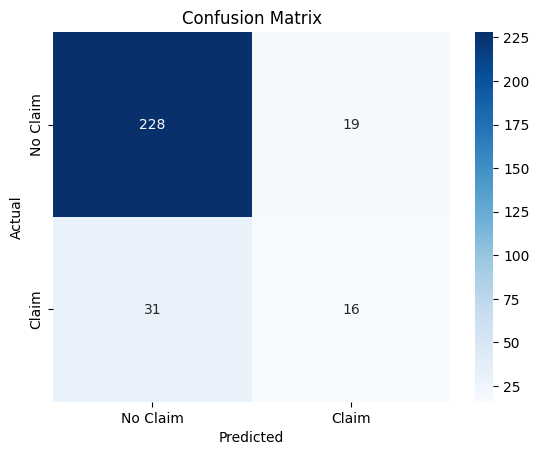

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       247
           1       0.46      0.34      0.39        47

    accuracy                           0.83       294
   macro avg       0.67      0.63      0.65       294
weighted avg       0.81      0.83      0.82       294


 ROC Curve for XGBoost


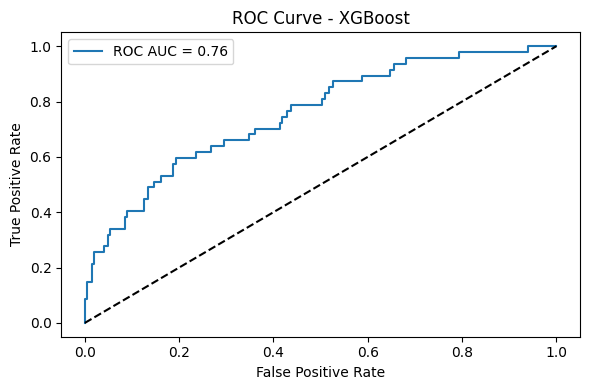


 XGBoost Feature Importance


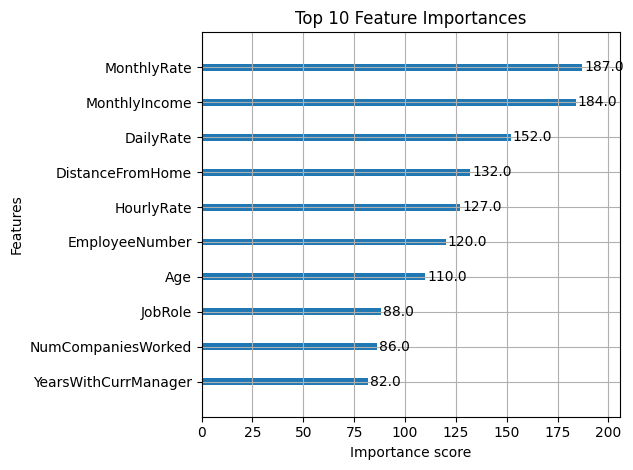


 SHAP Summary Plot


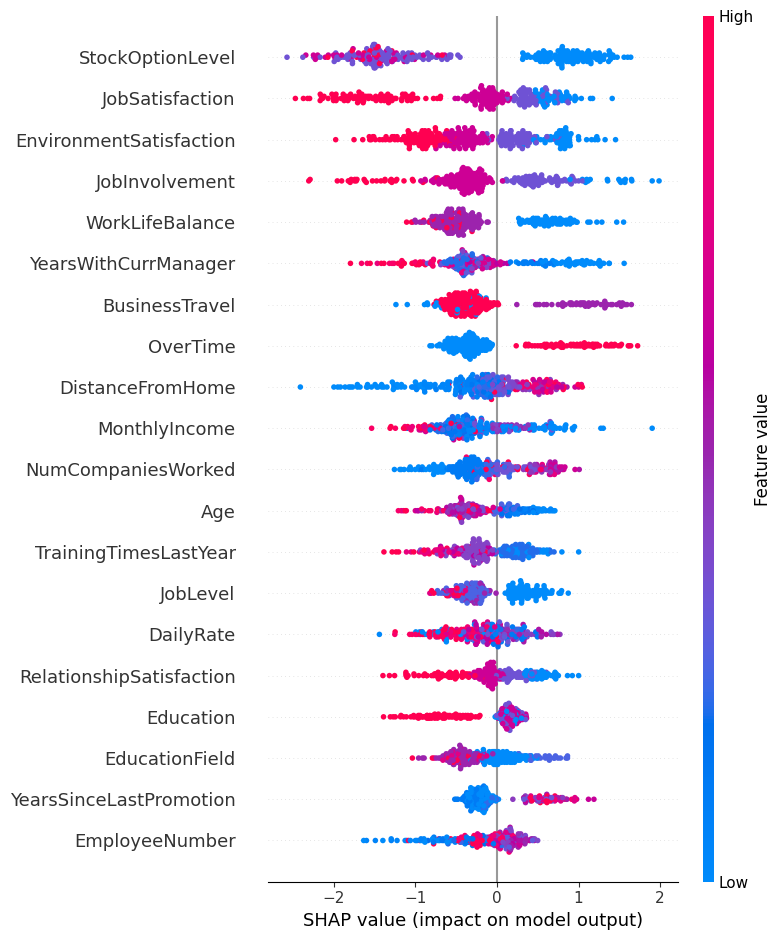

In [1]:
#  Employee Attrition ML Project 

# --- Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve
)
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# --- Load Dataset ---
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
print(" Dataset Loaded:", df.shape)

# --- Label Encode Categorical Columns ---
le_dict = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# --- Features and Target ---
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- SMOTE to Balance the Classes ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(" Class Distribution After SMOTE:", np.bincount(y_train_res))

# --- Scale for Logistic Regression ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# --- EDA: Correlation ---
print("\n Correlation Heatmap:")
plt.figure(figsize=(14, 6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# --- EDA: OverTime vs Attrition ---
print(" OverTime vs Attrition")
sns.countplot(x="OverTime", hue="Attrition", data=df)
plt.title("Attrition by OverTime")
plt.tight_layout()
plt.show()

# -----------------------------------
#  XGBoost
# -----------------------------------
try:
    print("\n==============================")
    print(" XGBoost")
    print("==============================")
    xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train_res, y_train_res)
    y_pred = xgb_model.predict(X_test)
    y_proba = xgb_model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Claim", "Claim"], yticklabels=["No Claim", "Claim"])
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    print("Classification Report:\n", classification_report(y_test, y_pred))
except Exception as e:
    print(" XGBoost failed:", e)

# --- ROC Curve for XGBoost ---
try:
    print("\n ROC Curve for XGBoost")
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - XGBoost")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(" ROC Curve failed:", e)

# --- Feature Importance (XGBoost) ---
try:
    print("\n XGBoost Feature Importance")
    xgb.plot_importance(xgb_model, max_num_features=10)
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(" Feature Importance failed:", e)

# --- SHAP Explainability ---
try:
    print("\n SHAP Summary Plot")
    explainer = shap.Explainer(xgb_model)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)
except Exception as e:
    print("SHAP failed:", e)
